In [7]:
import pickle
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import torch
import os
import cv2
import av
import matplotlib.gridspec as gridspec
from matplotlib.animation import FuncAnimation
from IPython.display import HTML


In [ ]:
def read_video(video_file:str) -> np.ndarray:
    """Reads a video file, returns frames(T,H,W,3) """
    VidObj = cv2.VideoCapture(video_file)
    VidObj.set(cv2.CAP_PROP_POS_MSEC, 0)
    success, frame = VidObj.read()
    frames = list()
    while success:
        frame = cv2.cvtColor(np.array(frame), cv2.COLOR_BGR2RGB)
        frame = np.asarray(frame)
        frames.append(frame)
        success, frame = VidObj.read()
    VidObj.release()
    return np.asarray(frames)

def read_16bit_video(video_file:str) -> np.ndarray:
    """Reads a 16-bit grayscale FFV1 MKV file, returns frames (T, H, W, 1) as uint16"""
    container = av.open(video_file)
    video_stream = container.streams.video[0]
    frames = []
    num_frames = video_stream.frames
    for frame in container.decode(video_stream): # type: ignore
        # Convert to a NumPy array in 16-bit grayscale
        frame_np = frame.to_ndarray(format="gray16le")
        # PyAV returns grayscale frames with shape (H, W)
        frames.append(frame_np)

    # Return all frames as a single NumPy array of shape (T, H, W)
    frames = np.expand_dims(np.asarray(frames, dtype=np.uint16),axis=-1) # changes type and expands dimensions
    return frames

def concordance_correlation_loss(x, y, eps=1e-8):
    # x and y are assumed to be 1D tensors or have matching shapes
    mean_x = torch.mean(x)
    mean_y = torch.mean(y)
    var_x = torch.var(x)
    var_y = torch.var(y)
    cov_xy = torch.mean((x - mean_x) * (y - mean_y))
    ccc = (2 * cov_xy) / (var_x + var_y + (mean_x - mean_y)**2 + eps)
    # Loss: 1 - CCC (so that perfect concordance gives 0 loss)
    return 1 - ccc

def finite_difference(x):
    # Computes a simple finite difference along the last dimension
    return x[..., 1:] - x[..., :-1]

def normalize_pressure_label(label:np.ndarray,min_val:float,max_val:float)->np.ndarray:
    """Normalize the pressure signal to a range of [-1,1]."""
    label = (label - min_val) / (max_val - min_val) * 2 - 1
    return label

def denormalize_pressure_label(label:np.ndarray,min_val:float,max_val:float)->np.ndarray:
    """Denormalize the pressure signal to its original range."""
    label = (label + 1) / 2 * (max_val - min_val) + min_val
    return label

def load_data(data_dict, label:str=None):
    for method, value in tqdm(data_dict.items()):
        outputs = pickle.load(open(data_dict[method]['path'],'rb'))
        recordings = list(outputs['labels'].keys())
        output_dict = {}
        if label == 'ABP':
            normmin=-50
            normmax=200
        elif label == 'CVP':
            normmin=-30
            normmax=40
        else:
            normmin, normmax = None, None
        for recording in tqdm(recordings,leave=False):
            labels = []
            for key, value in outputs['labels'][recording].items():
                labels.extend(value.squeeze())
            predictions = []
            for key, value in outputs['predictions'][recording].items():
                predictions.extend(value.squeeze())
            if (normmin is not None) and (normmax is not None):
                labels = denormalize_pressure_label(np.array(labels), normmin, normmax)
                predictions = denormalize_pressure_label(np.array(predictions), normmin, normmax)
            else:
                labels = np.array(labels)
                predictions = np.array(predictions)
            recording_dict = {recording: {'label': labels, 'prediction': predictions}}
            output_dict.update(recording_dict)
        data_dict[method]['output'] = output_dict
    return data_dict

def get_statistics(trace:np.array) -> dict:
    min = np.min(trace)
    max = np.max(trace)
    mean = np.mean(trace)
    std = np.std(trace)
    median = np.median(trace)
    stat_dict = {'min': min, 'max': max, 'mean': mean, 'std': std, 'median': median}
    return stat_dict

In [31]:
frame_range = slice(0,128)
recording = 'P057_S01_R1_0_D'
camera = 'K1'
vid_times = np.arange(frame_range.start/30, frame_range.stop/30,1/30)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/68 [00:00<?, ?it/s]

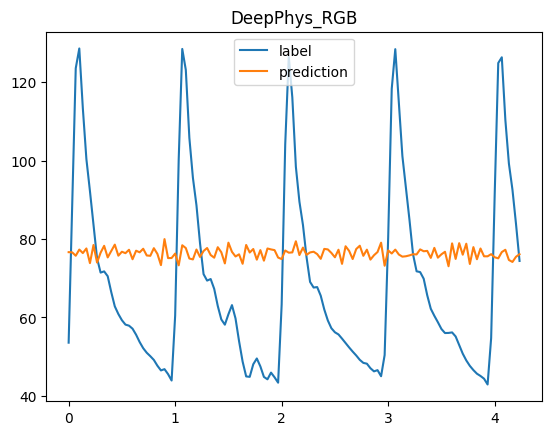

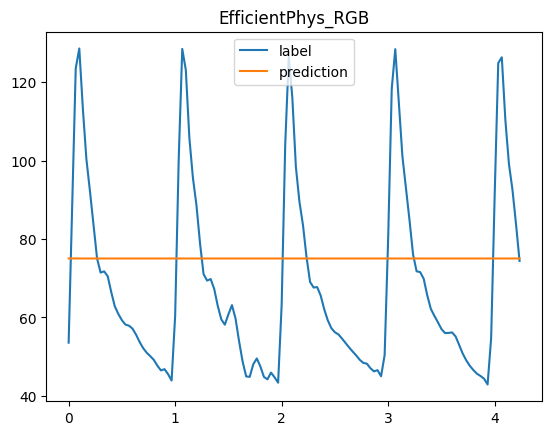

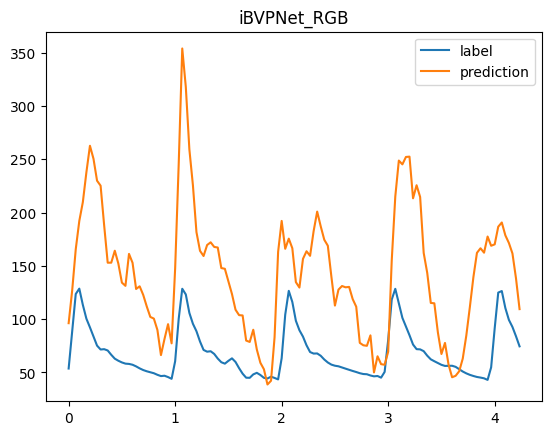

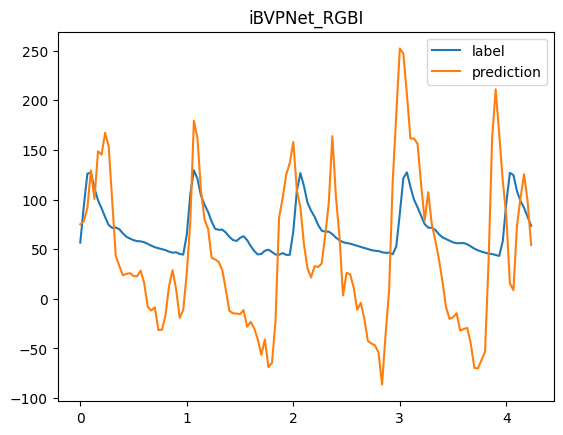

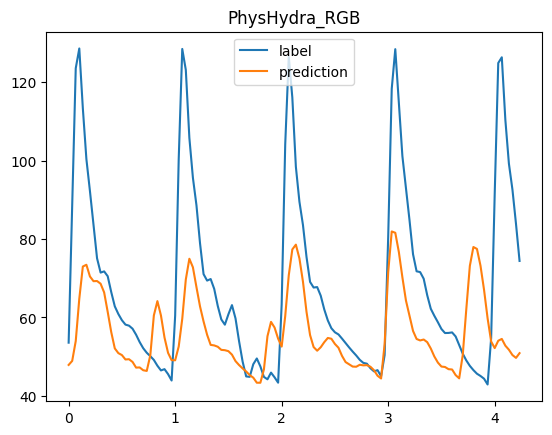

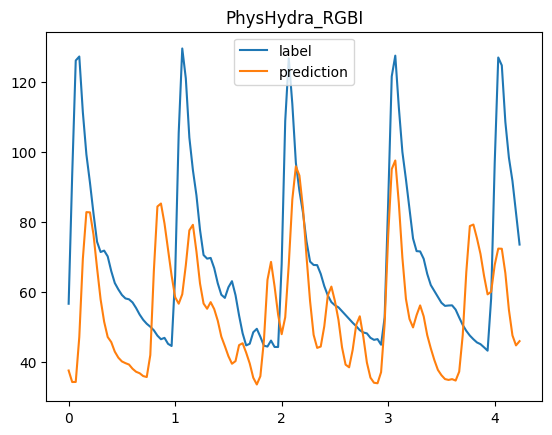

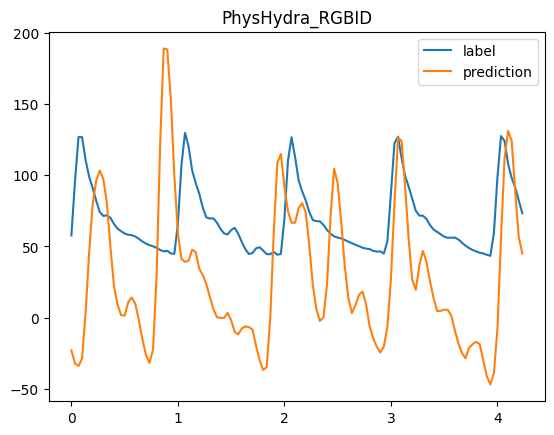

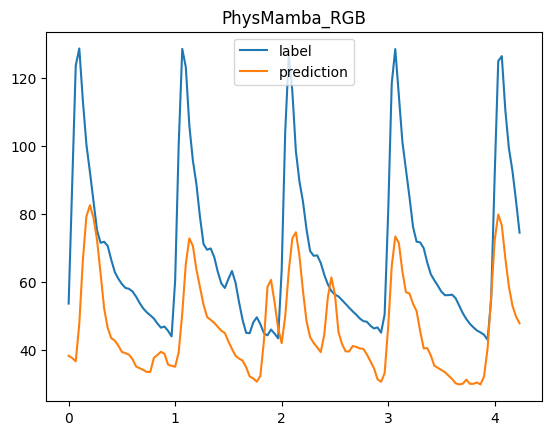

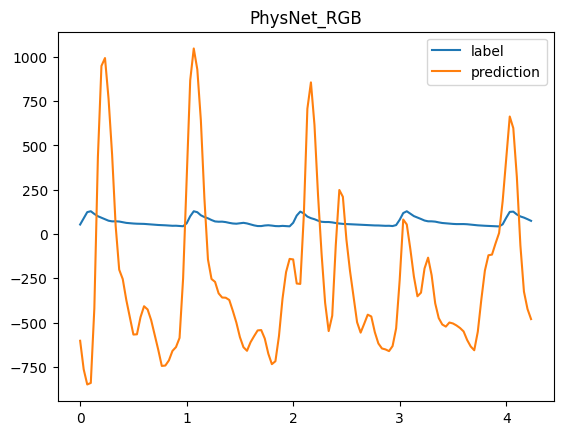

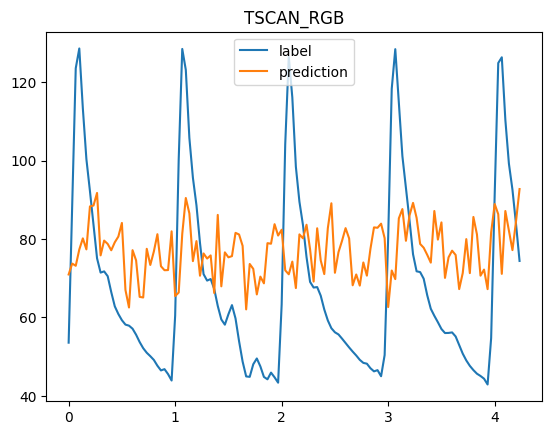

In [ ]:
deepphys_rgb = {'path': '/Users/20759193/Library/Mobile Documents/com~apple~CloudDocs/source/repos/rPPG-Toolbox/runs/exp/abp/defaults/DeepPhys_RGB/NECKFLIX_SizeW72_SizeH72_ClipLength180_DataTypeDiffNormalized_Standardized_DataAugNone_LabelTypeDiffNormalized_Crop_faceTrue_BackendHC_Large_boxTrue_Large_size1.5_Dyamic_DetFalse_det_len30_Median_face_boxFalse/saved_test_outputs/NECKFLIX_NECKFLIX_NECKFLIX_DeepPhys_outputs.pickle'}
efficientphys_rgb = {'path': '/Users/20759193/Library/Mobile Documents/com~apple~CloudDocs/source/repos/rPPG-Toolbox/runs/exp/abp/defaults/EfficientPhys_RGB/NECKFLIX_SizeW72_SizeH72_ClipLength180_DataTypeStandardized_DataAugNone_LabelTypeDiffNormalized_Crop_faceTrue_BackendHC_Large_boxTrue_Large_size1.5_Dyamic_DetFalse_det_len30_Median_face_boxFalse/saved_test_outputs/NECKFLIX_NECKFLIX_NECKFLIX_EfficientPhys_outputs.pickle'}
ibvpnet_rgb = {'path': '/Users/20759193/Library/Mobile Documents/com~apple~CloudDocs/source/repos/rPPG-Toolbox/runs/exp/abp/defaults/iBVPNet_RGB/NECKFLIX_SizeW72_SizeH72_ClipLength160_DataTypeRaw_DataAugNone_LabelTypeStandardized_Crop_faceTrue_BackendHC_Large_boxTrue_Large_size1.5_Dyamic_DetFalse_det_len30_Median_face_boxFalse/saved_test_outputs/NECKFLIX_NECKFLIX_NECKFLIX_iBVPNet_outputs.pickle'}
ibvpnet_rgbi = {'path': '/Users/20759193/Library/Mobile Documents/com~apple~CloudDocs/source/repos/rPPG-Toolbox/runs/exp/abp/defaults/iBVPNet_RGBI/NECKFLIX_SizeW72_SizeH72_ClipLength160_DataTypeRaw_DataAugNone_LabelTypeStandardized_Crop_faceTrue_BackendHC_Large_boxTrue_Large_size1.5_Dyamic_DetFalse_det_len30_Median_face_boxFalse/saved_test_outputs/NECKFLIX_NECKFLIX_NECKFLIX_iBVPNet_outputs.pickle'}
physhydra_rgb = {'path': '/Users/20759193/Library/Mobile Documents/com~apple~CloudDocs/source/repos/rPPG-Toolbox/runs/exp/abp/defaults/PhysHydra_RGB/NECKFLIX_SizeW128_SizeH128_ClipLength128_DataTypeDiffNormalized_DataAugNone_LabelTypeDiffNormalized_Crop_faceTrue_BackendHC_Large_boxTrue_Large_size1.5_Dyamic_DetFalse_det_len30_Median_face_boxFalse/saved_test_outputs/NECKFLIX_NECKFLIX_NECKFLIX_PhysHydra_outputs.pickle'}
physhydra_rgbi = {'path': '/Users/20759193/Library/Mobile Documents/com~apple~CloudDocs/source/repos/rPPG-Toolbox/runs/exp/abp/defaults/PhysHydra_RGBI/NECKFLIX_SizeW128_SizeH128_ClipLength128_DataTypeDiffNormalized_DataAugNone_LabelTypeDiffNormalized_Crop_faceTrue_BackendHC_Large_boxTrue_Large_size1.5_Dyamic_DetFalse_det_len30_Median_face_boxFalse/saved_test_outputs/NECKFLIX_NECKFLIX_NECKFLIX_PhysHydra_outputs.pickle'}
physhydra_rgbid = {'path': '/Users/20759193/Library/Mobile Documents/com~apple~CloudDocs/source/repos/rPPG-Toolbox/runs/exp/abp/defaults/PhysHydra_RGBID/NECKFLIX_SizeW128_SizeH128_ClipLength128_DataTypeDiffNormalized_DataAugNone_LabelTypeDiffNormalized_Crop_faceTrue_BackendHC_Large_boxTrue_Large_size1.5_Dyamic_DetFalse_det_len30_Median_face_boxFalse/saved_test_outputs/NECKFLIX_NECKFLIX_NECKFLIX_PhysHydra_outputs.pickle'}
physmamba_rgb = {'path': '/Users/20759193/Library/Mobile Documents/com~apple~CloudDocs/source/repos/rPPG-Toolbox/runs/exp/abp/defaults/PhysMamba_RGB/NECKFLIX_SizeW128_SizeH128_ClipLength128_DataTypeDiffNormalized_DataAugNone_LabelTypeDiffNormalized_Crop_faceTrue_BackendHC_Large_boxTrue_Large_size1.5_Dyamic_DetFalse_det_len30_Median_face_boxFalse/saved_test_outputs/NECKFLIX_NECKFLIX_NECKFLIX_PhysMamba_outputs.pickle'}
physnet_rgb = {'path': '/Users/20759193/Library/Mobile Documents/com~apple~CloudDocs/source/repos/rPPG-Toolbox/runs/exp/abp/defaults/PhysNet_RGB/NECKFLIX_SizeW72_SizeH72_ClipLength128_DataTypeDiffNormalized_DataAugNone_LabelTypeDiffNormalized_Crop_faceTrue_BackendHC_Large_boxTrue_Large_size1.5_Dyamic_DetFalse_det_len30_Median_face_boxFalse/saved_test_outputs/NECKFLIX_NECKFLIX_NECKFLIX_PhysNet_outputs.pickle'}
tscan_rgb = {'path': '/Users/20759193/Library/Mobile Documents/com~apple~CloudDocs/source/repos/rPPG-Toolbox/runs/exp/abp/defaults/TSCAN_RGB/NECKFLIX_SizeW72_SizeH72_ClipLength180_DataTypeDiffNormalized_Standardized_DataAugNone_LabelTypeDiffNormalized_Crop_faceTrue_BackendHC_Large_boxTrue_Large_size1.5_Dyamic_DetFalse_det_len30_Median_face_boxFalse/saved_test_outputs/NECKFLIX_NECKFLIX_NECKFLIX_TSCAN_outputs.pickle'}
abp = {'DeepPhys_RGB': deepphys_rgb, 
       'EfficientPhys_RGB': efficientphys_rgb, 
       'iBVPNet_RGB': ibvpnet_rgb, 
       'iBVPNet_RGBI': ibvpnet_rgbi, 
       'PhysHydra_RGB': physhydra_rgb, 
       'PhysHydra_RGBI': physhydra_rgbi, 
       'PhysHydra_RGBID': physhydra_rgbid, 
       'PhysMamba_RGB': physmamba_rgb, 
       'PhysNet_RGB': physnet_rgb, 
       'TSCAN_RGB': tscan_rgb}
abp = load_data(abp,label='ABP')
for key, value in abp.items():
    try:
        y1 = abp[key]['output'][f"{recording}_{camera}"]['label'][frame_range]
        y2 = abp[key]['output'][f"{recording}_{camera}"]['prediction'][frame_range]
        plt.plot(vid_times[0:len(y1)],y1, label='label')
        plt.plot(vid_times,y2, label='prediction')
        plt.legend()
        plt.title(key)
        plt.show()
    except Exception as e:
        print(e)

In [ ]:

label = abp['PhysMamba_RGB']['output'][f"{recording}_{camera}"]['label']
prediction = abp['PhysMamba_RGB']['output'][f"{recording}_{camera}"]['prediction']


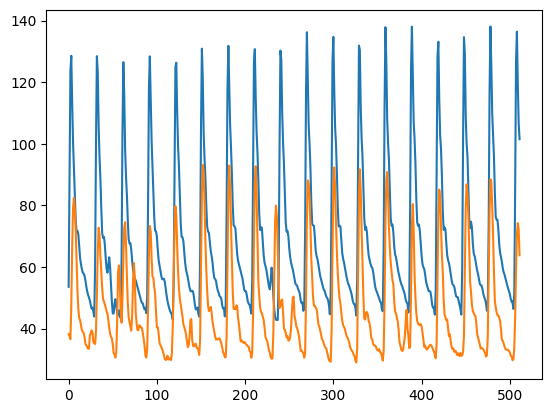

In [25]:
plt.plot(real_label, label='label')
plt.plot(real_prediction, label='prediction')
plt.show()

In [ ]:
label_stats = get_statistics()
prediction_stats = get_statistics()

In [19]:
mean_diff =  prediction_stats['mean'] - label_stats['mean']
std_diff = prediction_stats['std'] - label_stats['std']
median_diff = prediction_stats['median'] - label_stats['median']
min_diff = prediction_stats['min'] - label_stats['min']
max_diff = prediction_stats['max'] - label_stats['max']
range_diff = max_diff - min_diff
print(f"Mean difference: {mean_diff}")
print(f"Std difference: {std_diff}")
print(f"Median difference: {median_diff}")
print(f"Min difference: {min_diff}")
print(f"Max difference: {max_diff}")
print(f"Range difference: {range_diff}")


Mean difference: 0.05506450682878494
Std difference: -0.13627628982067108
Median difference: 0.1276245415210724
Min difference: 0.1357111930847168
Max difference: -0.34517598152160645
Range difference: -0.48088717460632324


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

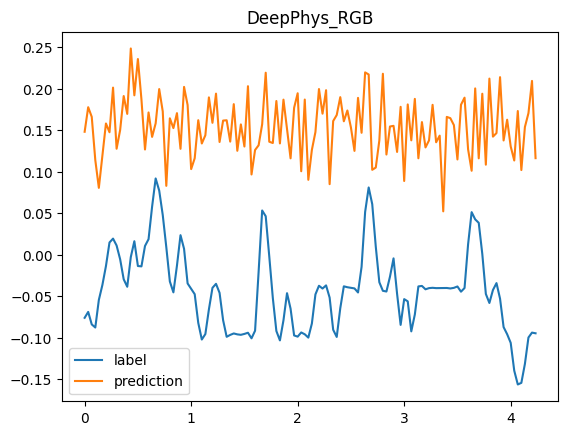

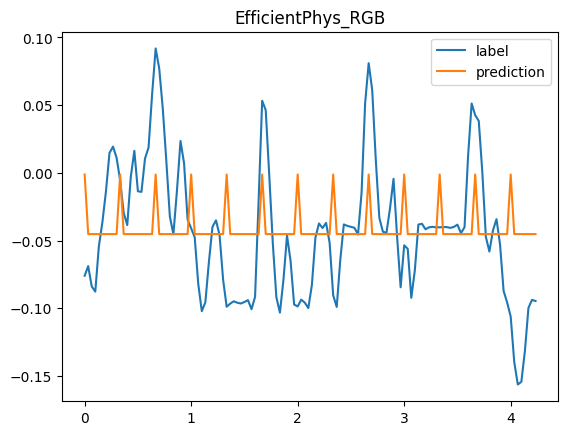

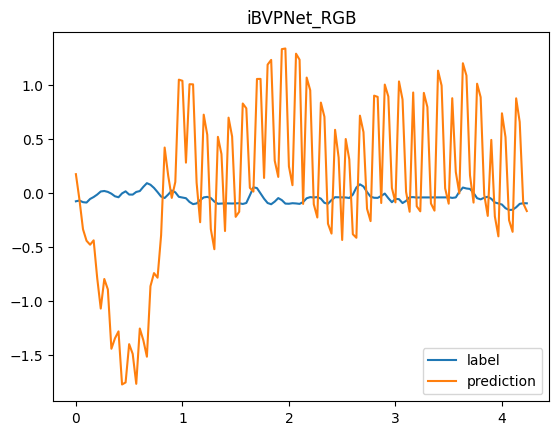

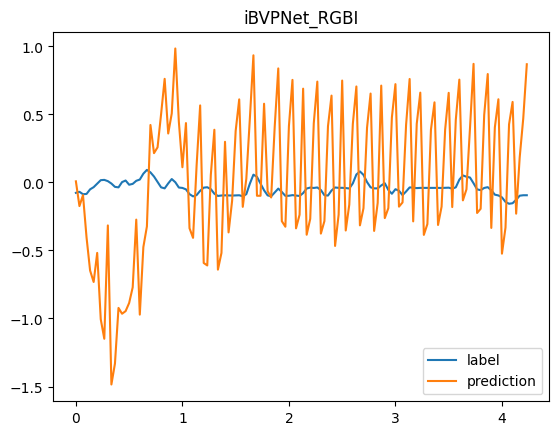

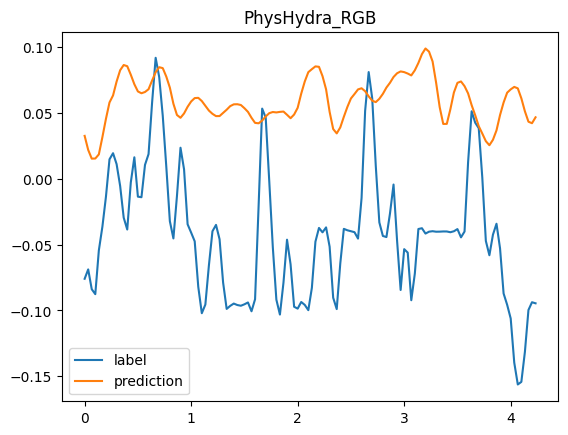

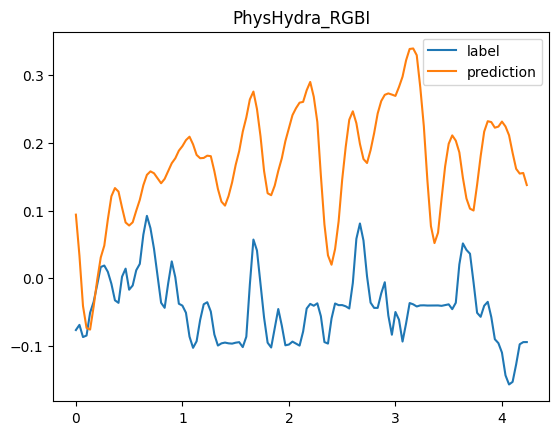

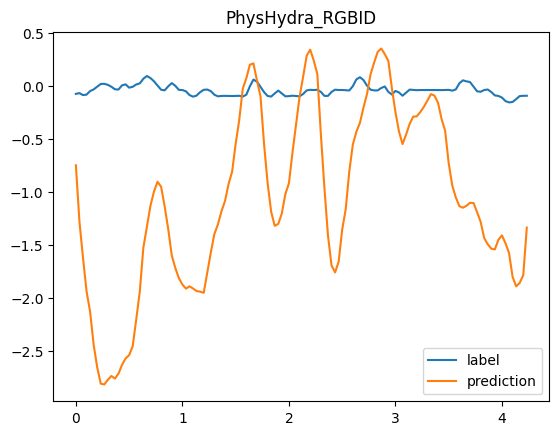

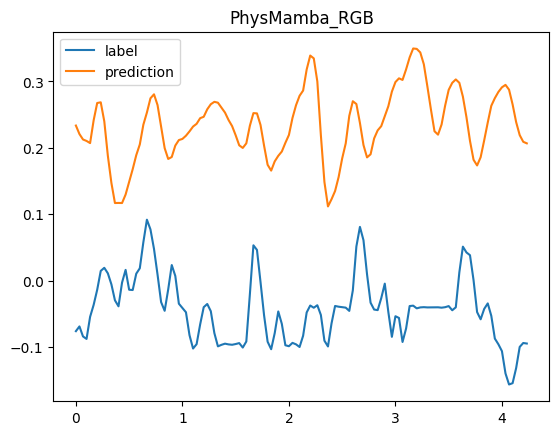

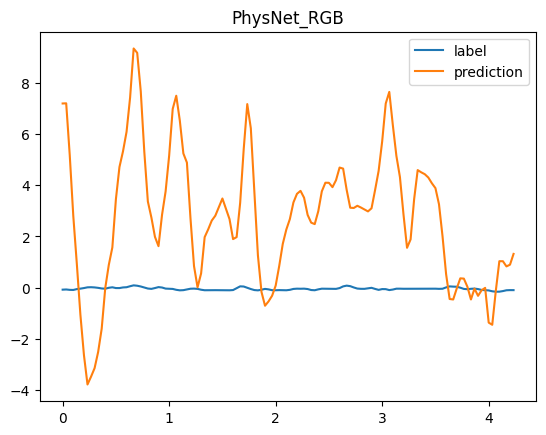

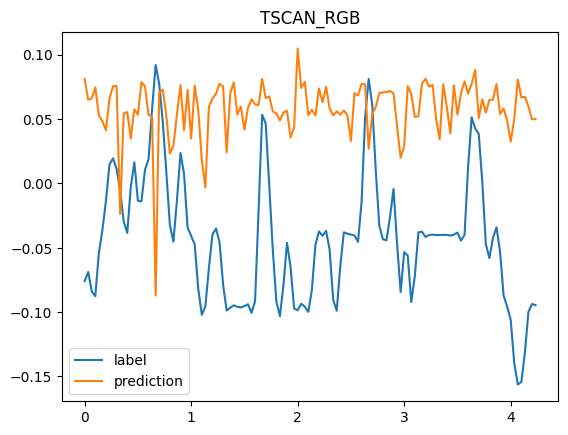

In [13]:
deepphys_rgb = {'path': '/Users/20759193/Library/Mobile Documents/com~apple~CloudDocs/source/repos/rPPG-Toolbox/runs/exp/cvp/defaults/DeepPhys_RGB/NECKFLIX_SizeW72_SizeH72_ClipLength180_DataTypeDiffNormalized_Standardized_DataAugNone_LabelTypeDiffNormalized_Crop_faceTrue_BackendHC_Large_boxTrue_Large_size1.5_Dyamic_DetFalse_det_len30_Median_face_boxFalse/saved_test_outputs/NECKFLIX_NECKFLIX_NECKFLIX_DeepPhys_outputs.pickle'}
efficientphys_rgb = {'path': '/Users/20759193/Library/Mobile Documents/com~apple~CloudDocs/source/repos/rPPG-Toolbox/runs/exp/cvp/defaults/EfficientPhys_RGB/NECKFLIX_SizeW72_SizeH72_ClipLength180_DataTypeStandardized_DataAugNone_LabelTypeDiffNormalized_Crop_faceTrue_BackendHC_Large_boxTrue_Large_size1.5_Dyamic_DetFalse_det_len30_Median_face_boxFalse/saved_test_outputs/NECKFLIX_NECKFLIX_NECKFLIX_EfficientPhys_outputs.pickle'}
ibvpnet_rgb = {'path': '/Users/20759193/Library/Mobile Documents/com~apple~CloudDocs/source/repos/rPPG-Toolbox/runs/exp/cvp/defaults/iBVPNet_RGB/NECKFLIX_SizeW72_SizeH72_ClipLength160_DataTypeRaw_DataAugNone_LabelTypeStandardized_Crop_faceTrue_BackendHC_Large_boxTrue_Large_size1.5_Dyamic_DetFalse_det_len30_Median_face_boxFalse/saved_test_outputs/NECKFLIX_NECKFLIX_NECKFLIX_iBVPNet_outputs.pickle'}
ibvpnet_rgbi = {'path': '/Users/20759193/Library/Mobile Documents/com~apple~CloudDocs/source/repos/rPPG-Toolbox/runs/exp/cvp/defaults/iBVPNet_RGBI/NECKFLIX_SizeW72_SizeH72_ClipLength160_DataTypeRaw_DataAugNone_LabelTypeStandardized_Crop_faceTrue_BackendHC_Large_boxTrue_Large_size1.5_Dyamic_DetFalse_det_len30_Median_face_boxFalse/saved_test_outputs/NECKFLIX_NECKFLIX_NECKFLIX_iBVPNet_outputs.pickle'}
physhydra_rgb = {'path': '/Users/20759193/Library/Mobile Documents/com~apple~CloudDocs/source/repos/rPPG-Toolbox/runs/exp/cvp/defaults/PhysHydra_RGB/NECKFLIX_SizeW128_SizeH128_ClipLength128_DataTypeDiffNormalized_DataAugNone_LabelTypeDiffNormalized_Crop_faceTrue_BackendHC_Large_boxTrue_Large_size1.5_Dyamic_DetFalse_det_len30_Median_face_boxFalse/saved_test_outputs/NECKFLIX_NECKFLIX_NECKFLIX_PhysHydra_outputs.pickle'}
physhydra_rgbi = {'path': '/Users/20759193/Library/Mobile Documents/com~apple~CloudDocs/source/repos/rPPG-Toolbox/runs/exp/cvp/defaults/PhysHydra_RGBI/NECKFLIX_SizeW128_SizeH128_ClipLength128_DataTypeDiffNormalized_DataAugNone_LabelTypeDiffNormalized_Crop_faceTrue_BackendHC_Large_boxTrue_Large_size1.5_Dyamic_DetFalse_det_len30_Median_face_boxFalse/saved_test_outputs/NECKFLIX_NECKFLIX_NECKFLIX_PhysHydra_outputs.pickle'}
physhydra_rgbid = {'path': '/Users/20759193/Library/Mobile Documents/com~apple~CloudDocs/source/repos/rPPG-Toolbox/runs/exp/cvp/defaults/PhysHydra_RGBID/NECKFLIX_SizeW128_SizeH128_ClipLength128_DataTypeDiffNormalized_DataAugNone_LabelTypeDiffNormalized_Crop_faceTrue_BackendHC_Large_boxTrue_Large_size1.5_Dyamic_DetFalse_det_len30_Median_face_boxFalse/saved_test_outputs/NECKFLIX_NECKFLIX_NECKFLIX_PhysHydra_outputs.pickle'}
physmamba_rgb = {'path': '/Users/20759193/Library/Mobile Documents/com~apple~CloudDocs/source/repos/rPPG-Toolbox/runs/exp/cvp/defaults/PhysMamba_RGB/NECKFLIX_SizeW128_SizeH128_ClipLength128_DataTypeDiffNormalized_DataAugNone_LabelTypeDiffNormalized_Crop_faceTrue_BackendHC_Large_boxTrue_Large_size1.5_Dyamic_DetFalse_det_len30_Median_face_boxFalse/saved_test_outputs/NECKFLIX_NECKFLIX_NECKFLIX_PhysMamba_outputs.pickle'}
physnet_rgb = {'path': '/Users/20759193/Library/Mobile Documents/com~apple~CloudDocs/source/repos/rPPG-Toolbox/runs/exp/cvp/defaults/PhysNet_RGB/NECKFLIX_SizeW72_SizeH72_ClipLength128_DataTypeDiffNormalized_DataAugNone_LabelTypeDiffNormalized_Crop_faceTrue_BackendHC_Large_boxTrue_Large_size1.5_Dyamic_DetFalse_det_len30_Median_face_boxFalse/saved_test_outputs/NECKFLIX_NECKFLIX_NECKFLIX_PhysNet_outputs.pickle'}
tscan_rgb = {'path': '/Users/20759193/Library/Mobile Documents/com~apple~CloudDocs/source/repos/rPPG-Toolbox/runs/exp/cvp/defaults/TSCAN_RGB/NECKFLIX_SizeW72_SizeH72_ClipLength180_DataTypeDiffNormalized_Standardized_DataAugNone_LabelTypeDiffNormalized_Crop_faceTrue_BackendHC_Large_boxTrue_Large_size1.5_Dyamic_DetFalse_det_len30_Median_face_boxFalse/saved_test_outputs/NECKFLIX_NECKFLIX_NECKFLIX_TSCAN_outputs.pickle'}
cvp = {'DeepPhys_RGB': deepphys_rgb, 
       'EfficientPhys_RGB': efficientphys_rgb, 
       'iBVPNet_RGB': ibvpnet_rgb, 
       'iBVPNet_RGBI': ibvpnet_rgbi, 
       'PhysHydra_RGB': physhydra_rgb, 
       'PhysHydra_RGBI': physhydra_rgbi, 
       'PhysHydra_RGBID': physhydra_rgbid, 
       'PhysMamba_RGB': physmamba_rgb, 
       'PhysNet_RGB': physnet_rgb, 
       'TSCAN_RGB': tscan_rgb}
cvp = load_data(cvp)
for key, value in cvp.items():
    try:
        y1 = cvp[key]['output'][f"{recording}_{camera}"]['label'][frame_range]
        y2 = cvp[key]['output'][f"{recording}_{camera}"]['prediction'][frame_range]
        plt.plot(vid_times,y1, label='label')
        plt.plot(vid_times,y2, label='prediction')
        plt.legend()
        plt.title(key)
        plt.show()
    except Exception as e:
        print(e)

In [ ]:
deepphys_rgb = {'path': '/Users/20759193/Library/Mobile Documents/com~apple~CloudDocs/source/repos/rPPG-Toolbox/runs/exp/ecg/defaults/DeepPhys_RGB/NECKFLIX_SizeW72_SizeH72_ClipLength180_DataTypeDiffNormalized_Standardized_DataAugNone_LabelTypeDiffNormalized_Crop_faceTrue_BackendHC_Large_boxTrue_Large_size1.5_Dyamic_DetFalse_det_len30_Median_face_boxFalse/saved_test_outputs/NECKFLIX_NECKFLIX_NECKFLIX_DeepPhys_outputs.pickle'}
efficientphys_rgb = {'path': '/Users/20759193/Library/Mobile Documents/com~apple~CloudDocs/source/repos/rPPG-Toolbox/runs/exp/ecg/defaults/EfficientPhys_RGB/NECKFLIX_SizeW72_SizeH72_ClipLength180_DataTypeStandardized_DataAugNone_LabelTypeDiffNormalized_Crop_faceTrue_BackendHC_Large_boxTrue_Large_size1.5_Dyamic_DetFalse_det_len30_Median_face_boxFalse/saved_test_outputs/NECKFLIX_NECKFLIX_NECKFLIX_EfficientPhys_outputs.pickle'}
ibvpnet_rgb = {'path': '/Users/20759193/Library/Mobile Documents/com~apple~CloudDocs/source/repos/rPPG-Toolbox/runs/exp/ecg/defaults/iBVPNet_RGB/NECKFLIX_SizeW72_SizeH72_ClipLength160_DataTypeRaw_DataAugNone_LabelTypeStandardized_Crop_faceTrue_BackendHC_Large_boxTrue_Large_size1.5_Dyamic_DetFalse_det_len30_Median_face_boxFalse/saved_test_outputs/NECKFLIX_NECKFLIX_NECKFLIX_iBVPNet_outputs.pickle'}
ibvpnet_rgbi = {'path': '/Users/20759193/Library/Mobile Documents/com~apple~CloudDocs/source/repos/rPPG-Toolbox/runs/exp/ecg/defaults/iBVPNet_RGBI/NECKFLIX_SizeW72_SizeH72_ClipLength160_DataTypeRaw_DataAugNone_LabelTypeStandardized_Crop_faceTrue_BackendHC_Large_boxTrue_Large_size1.5_Dyamic_DetFalse_det_len30_Median_face_boxFalse/RGBI/saved_test_outputs/NECKFLIX_NECKFLIX_NECKFLIX_iBVPNet_outputs.pickle'}
physhydra_rgb = {'path': '/Users/20759193/Library/Mobile Documents/com~apple~CloudDocs/source/repos/rPPG-Toolbox/runs/exp/ecg/defaults/PhysHydra_RGB/NECKFLIX_SizeW128_SizeH128_ClipLength128_DataTypeDiffNormalized_DataAugNone_LabelTypeDiffNormalized_Crop_faceTrue_BackendHC_Large_boxTrue_Large_size1.5_Dyamic_DetFalse_det_len30_Median_face_boxFalse/saved_test_outputs/NECKFLIX_NECKFLIX_NECKFLIX_PhysHydra_outputs.pickle'}
physhydra_rgbi = {'path': '/Users/20759193/Library/Mobile Documents/com~apple~CloudDocs/source/repos/rPPG-Toolbox/runs/exp/ecg/defaults/PhysHydra_RGBI/NECKFLIX_SizeW128_SizeH128_ClipLength128_DataTypeDiffNormalized_DataAugNone_LabelTypeDiffNormalized_Crop_faceTrue_BackendHC_Large_boxTrue_Large_size1.5_Dyamic_DetFalse_det_len30_Median_face_boxFalse/saved_test_outputs/NECKFLIX_NECKFLIX_NECKFLIX_PhysHydra_outputs.pickle'}
physhydra_rgbid = {'path': '/Users/20759193/Library/Mobile Documents/com~apple~CloudDocs/source/repos/rPPG-Toolbox/runs/exp/ecg/defaults/PhysHydra_RGBID/NECKFLIX_SizeW128_SizeH128_ClipLength128_DataTypeDiffNormalized_DataAugNone_LabelTypeDiffNormalized_Crop_faceTrue_BackendHC_Large_boxTrue_Large_size1.5_Dyamic_DetFalse_det_len30_Median_face_boxFalse/saved_test_outputs/NECKFLIX_NECKFLIX_NECKFLIX_PhysHydra_outputs.pickle'}
physmamba_rgb = {'path': '/Users/20759193/Library/Mobile Documents/com~apple~CloudDocs/source/repos/rPPG-Toolbox/runs/exp/ecg/defaults/PhysMamba_RGB/NECKFLIX_SizeW128_SizeH128_ClipLength128_DataTypeDiffNormalized_DataAugNone_LabelTypeDiffNormalized_Crop_faceTrue_BackendHC_Large_boxTrue_Large_size1.5_Dyamic_DetFalse_det_len30_Median_face_boxFalse/saved_test_outputs/NECKFLIX_NECKFLIX_NECKFLIX_PhysMamba_outputs.pickle'}
physnet_rgb = {'path': '/Users/20759193/Library/Mobile Documents/com~apple~CloudDocs/source/repos/rPPG-Toolbox/runs/exp/ecg/defaults/PhysNet_RGB/NECKFLIX_SizeW72_SizeH72_ClipLength128_DataTypeDiffNormalized_DataAugNone_LabelTypeDiffNormalized_Crop_faceTrue_BackendHC_Large_boxTrue_Large_size1.5_Dyamic_DetFalse_det_len30_Median_face_boxFalse/saved_test_outputs/NECKFLIX_NECKFLIX_NECKFLIX_PhysNet_outputs.pickle'}
tscan_rgb = {'path': '/Users/20759193/Library/Mobile Documents/com~apple~CloudDocs/source/repos/rPPG-Toolbox/runs/exp/ecg/defaults/TSCAN_RGB/NECKFLIX_SizeW72_SizeH72_ClipLength180_DataTypeDiffNormalized_Standardized_DataAugNone_LabelTypeDiffNormalized_Crop_faceTrue_BackendHC_Large_boxTrue_Large_size1.5_Dyamic_DetFalse_det_len30_Median_face_boxFalse/saved_test_outputs/NECKFLIX_NECKFLIX_NECKFLIX_TSCAN_outputs.pickle'}
ecg = {'DeepPhys_RGB': deepphys_rgb, 
       'EfficientPhys_RGB': efficientphys_rgb, 
       'iBVPNet_RGB': ibvpnet_rgb, 
       'iBVPNet_RGBI': ibvpnet_rgbi, 
       'PhysHydra_RGB': physhydra_rgb, 
       'PhysHydra_RGBI': physhydra_rgbi, 
       'PhysHydra_RGBID': physhydra_rgbid, 
       'PhysMamba_RGB': physmamba_rgb, 
       'PhysNet_RGB': physnet_rgb, 
       'TSCAN_RGB': tscan_rgb}
ecg = load_data(ecg)
for key, value in ecg.items():
    try:
        y1 = ecg[key]['output'][f"{recording}_{camera}"]['label'][frame_range]
        y2 = ecg[key]['output'][f"{recording}_{camera}"]['prediction'][frame_range]
        plt.plot(vid_times,y1, label='label')
        plt.plot(vid_times,y2, label='prediction')
        plt.legend()
        plt.title(key)
        plt.show()
    except Exception as e:
        print(e)

In [ ]:
def make_figures(output_path):
    outputs = pickle.load(open(output_path, "rb"))
    recordings = list(outputs['labels'].keys())
    figures = []
    for recording in tqdm(recordings):
        labels = []
        for key, value in outputs['labels'][recording].items():
            labels.append(value)
        predictions = []
        for key, value in outputs['predictions'][recording].items():
            predictions.append(value)
        n_plots = len(labels)
        fig, axs = plt.subplots(n_plots, 1, figsize=(6, n_plots),sharex=True, sharey=True)
        for i in range(n_plots):
            if i == 0:
                axs[i].plot(labels[i], label='label')
                axs[i].plot(predictions[i].squeeze(), label='prediction')
                axs[i].set_xticks([])
            elif i != n_plots - 1:
                # turn off the xticks
                axs[i].plot(labels[i])
                axs[i].plot(predictions[i].squeeze())
                axs[i].set_xticks([])
            else:
                axs[i].plot(labels[i])
                axs[i].plot(predictions[i].squeeze())
        # add a single axis legend to the right
        fig.legend(loc='center right', bbox_to_anchor=(1.05, 0.5))
        fig.suptitle(f"{recording}")
        figures.append(fig)
        plt.close(fig)
    return figures

# PhysMamba-RGB

In [ ]:
abp_path = "/Users/20759193/Library/Mobile Documents/com~apple~CloudDocs/source/repos/rPPG-Toolbox/runs/exp/abp/defaults/PhysMamba_RGB/NECKFLIX_SizeW128_SizeH128_ClipLength128_DataTypeDiffNormalized_DataAugNone_LabelTypeDiffNormalized_Crop_faceTrue_BackendHC_Large_boxTrue_Large_size1.5_Dyamic_DetFalse_det_len30_Median_face_boxFalse/saved_test_outputs/NECKFLIX_NECKFLIX_NECKFLIX_PhysMamba_outputs.pickle"
abp_figures = make_figures(abp_path)
cvp_path = "/Users/20759193/Library/Mobile Documents/com~apple~CloudDocs/source/repos/rPPG-Toolbox/runs/exp/cvp/defaults/PhysMamba_RGB/NECKFLIX_SizeW128_SizeH128_ClipLength128_DataTypeDiffNormalized_DataAugNone_LabelTypeDiffNormalized_Crop_faceTrue_BackendHC_Large_boxTrue_Large_size1.5_Dyamic_DetFalse_det_len30_Median_face_boxFalse/saved_test_outputs/NECKFLIX_NECKFLIX_NECKFLIX_PhysMamba_outputs.pickle"
cvp_figures = make_figures(cvp_path)
ecg_path = "/Users/20759193/Library/Mobile Documents/com~apple~CloudDocs/source/repos/rPPG-Toolbox/runs/exp/ecg/defaults/PhysMamba_RGB/NECKFLIX_SizeW128_SizeH128_ClipLength128_DataTypeDiffNormalized_DataAugNone_LabelTypeDiffNormalized_Crop_faceTrue_BackendHC_Large_boxTrue_Large_size1.5_Dyamic_DetFalse_det_len30_Median_face_boxFalse/saved_test_outputs/NECKFLIX_NECKFLIX_NECKFLIX_PhysMamba_outputs.pickle"
ecg_figures = make_figures(ecg_path)

In [ ]:
display(abp_figures[0])
display(cvp_figures[0])
display(ecg_figures[0])

# PhysHydra RGB

In [ ]:
abp_path = "/Users/20759193/Library/Mobile Documents/com~apple~CloudDocs/source/repos/rPPG-Toolbox/runs/exp/abp/defaults/PhysHydra_RGB/NECKFLIX_SizeW128_SizeH128_ClipLength128_DataTypeDiffNormalized_DataAugNone_LabelTypeDiffNormalized_Crop_faceTrue_BackendHC_Large_boxTrue_Large_size1.5_Dyamic_DetFalse_det_len30_Median_face_boxFalse/saved_test_outputs/NECKFLIX_NECKFLIX_NECKFLIX_PhysHydra_outputs.pickle"
abp_figures = make_figures(abp_path)
cvp_path = "/Users/20759193/Library/Mobile Documents/com~apple~CloudDocs/source/repos/rPPG-Toolbox/runs/exp/cvp/defaults/PhysHydra_RGB/NECKFLIX_SizeW128_SizeH128_ClipLength128_DataTypeDiffNormalized_DataAugNone_LabelTypeDiffNormalized_Crop_faceTrue_BackendHC_Large_boxTrue_Large_size1.5_Dyamic_DetFalse_det_len30_Median_face_boxFalse/saved_test_outputs/NECKFLIX_NECKFLIX_NECKFLIX_PhysHydra_outputs.pickle"
cvp_figures = make_figures(cvp_path)
ecg_path = "/Users/20759193/Library/Mobile Documents/com~apple~CloudDocs/source/repos/rPPG-Toolbox/runs/exp/ecg/defaults/PhysHydra_RGB/NECKFLIX_SizeW128_SizeH128_ClipLength128_DataTypeDiffNormalized_DataAugNone_LabelTypeDiffNormalized_Crop_faceTrue_BackendHC_Large_boxTrue_Large_size1.5_Dyamic_DetFalse_det_len30_Median_face_boxFalse/saved_test_outputs/NECKFLIX_NECKFLIX_NECKFLIX_PhysHydra_outputs.pickle"
ecg_figures = make_figures(ecg_path)

In [ ]:
display(abp_figures[0])
display(cvp_figures[0])
display(ecg_figures[0])

# PhysHydra RGBI

In [ ]:
abp_path = "/Users/20759193/Library/Mobile Documents/com~apple~CloudDocs/source/repos/rPPG-Toolbox/runs/exp/abp/defaults/PhysHydra_RGBI/NECKFLIX_SizeW128_SizeH128_ClipLength128_DataTypeDiffNormalized_DataAugNone_LabelTypeDiffNormalized_Crop_faceTrue_BackendHC_Large_boxTrue_Large_size1.5_Dyamic_DetFalse_det_len30_Median_face_boxFalse/saved_test_outputs/NECKFLIX_NECKFLIX_NECKFLIX_PhysHydra_outputs.pickle"
abp_figures = make_figures(abp_path)
cvp_path = "/Users/20759193/Library/Mobile Documents/com~apple~CloudDocs/source/repos/rPPG-Toolbox/runs/exp/cvp/defaults/PhysHydra_RGBI/NECKFLIX_SizeW128_SizeH128_ClipLength128_DataTypeDiffNormalized_DataAugNone_LabelTypeDiffNormalized_Crop_faceTrue_BackendHC_Large_boxTrue_Large_size1.5_Dyamic_DetFalse_det_len30_Median_face_boxFalse/saved_test_outputs/NECKFLIX_NECKFLIX_NECKFLIX_PhysHydra_outputs.pickle"
cvp_figures = make_figures(cvp_path)
ecg_path = "/Users/20759193/Library/Mobile Documents/com~apple~CloudDocs/source/repos/rPPG-Toolbox/runs/exp/ecg/defaults/PhysHydra_RGBI/NECKFLIX_SizeW128_SizeH128_ClipLength128_DataTypeDiffNormalized_DataAugNone_LabelTypeDiffNormalized_Crop_faceTrue_BackendHC_Large_boxTrue_Large_size1.5_Dyamic_DetFalse_det_len30_Median_face_boxFalse/saved_test_outputs/NECKFLIX_NECKFLIX_NECKFLIX_PhysHydra_outputs.pickle"
ecg_figures = make_figures(ecg_path)

In [ ]:
display(abp_figures[0])
display(cvp_figures[0])
display(ecg_figures[0])

# PhysHydra RGBID

In [ ]:
abp_path = "/Users/20759193/Library/Mobile Documents/com~apple~CloudDocs/source/repos/rPPG-Toolbox/runs/exp/abp/defaults/PhysHydra_RGBID/NECKFLIX_SizeW128_SizeH128_ClipLength128_DataTypeDiffNormalized_DataAugNone_LabelTypeDiffNormalized_Crop_faceTrue_BackendHC_Large_boxTrue_Large_size1.5_Dyamic_DetFalse_det_len30_Median_face_boxFalse/saved_test_outputs/NECKFLIX_NECKFLIX_NECKFLIX_PhysHydra_outputs.pickle"
abp_figures = make_figures(abp_path)
cvp_path = "/Users/20759193/Library/Mobile Documents/com~apple~CloudDocs/source/repos/rPPG-Toolbox/runs/exp/cvp/defaults/PhysHydra_RGBID/NECKFLIX_SizeW128_SizeH128_ClipLength128_DataTypeDiffNormalized_DataAugNone_LabelTypeDiffNormalized_Crop_faceTrue_BackendHC_Large_boxTrue_Large_size1.5_Dyamic_DetFalse_det_len30_Median_face_boxFalse/saved_test_outputs/NECKFLIX_NECKFLIX_NECKFLIX_PhysHydra_outputs.pickle"
cvp_figures = make_figures(cvp_path)
ecg_path = "/Users/20759193/Library/Mobile Documents/com~apple~CloudDocs/source/repos/rPPG-Toolbox/runs/exp/ecg/defaults/PhysHydra_RGBID/NECKFLIX_SizeW128_SizeH128_ClipLength128_DataTypeDiffNormalized_DataAugNone_LabelTypeDiffNormalized_Crop_faceTrue_BackendHC_Large_boxTrue_Large_size1.5_Dyamic_DetFalse_det_len30_Median_face_boxFalse/saved_test_outputs/NECKFLIX_NECKFLIX_NECKFLIX_PhysHydra_outputs.pickle"
ecg_figures = make_figures(ecg_path)